In [30]:
import tensorflow as tf
import keras
import numpy as np

In [31]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# 生成莎士比亚文本

In [32]:
shakespeare_url = "https://homl.info/shakespeare"  # shortcut URL
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [33]:
print(shakespeare_text[:80])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


In [34]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [35]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True) 
# Tokenizer分词器，char_level字符级编码，文本默认转小写，除非lower=False
# n个编码是从1到n，而不是0到n-1，因此在后面要整个序列减去1
tokenizer.fit_on_texts([shakespeare_text])

In [36]:
tokenizer.texts_to_sequences(['First']) # first编码成序列

[[20, 6, 9, 8, 3]]

In [37]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]]) # 序列编码成单词

['f i r s t']

In [38]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

## 拆分数据集

In [39]:
np.array(tokenizer.texts_to_sequences([shakespeare_text]))

array([[20,  6,  9, ..., 21, 27, 11]])

In [40]:
[encoded] # 每个编码减去1

[array([19,  5,  8, ..., 20, 26, 10])]

In [41]:
encoded.shape # 长度有一百多万

(1115394,)

In [42]:
dataset_size = len(encoded)
train_size = dataset_size * 90 // 100 # 注意整除
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size]) # 返回该集合的每个字符
n_steps = 100
window_length = n_steps + 1 # 目标 = 输入向前移动一个字符 ?没懂
dataset = dataset.window(window_length, shift=1, drop_remainder=True)
# window()方法把长字符串转换为若干小文本窗口，shift=1，第一个窗口包含0到100字符，第二个窗口包含1到101字符
# drop_remainder=True 丢掉最后小于n_steps的部分
# RNN不能学习比n_steps更长的模式，因此也不能太短

In [43]:
dataset = dataset.flat_map(lambda window: window.batch(window_length)) # 展平，见下图

In [44]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size) 
# 打乱10000个，shuffle参数等于数据集大小最好，必须先shuffle再batch
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:])) # 0~100对应1~101

以上处理图示
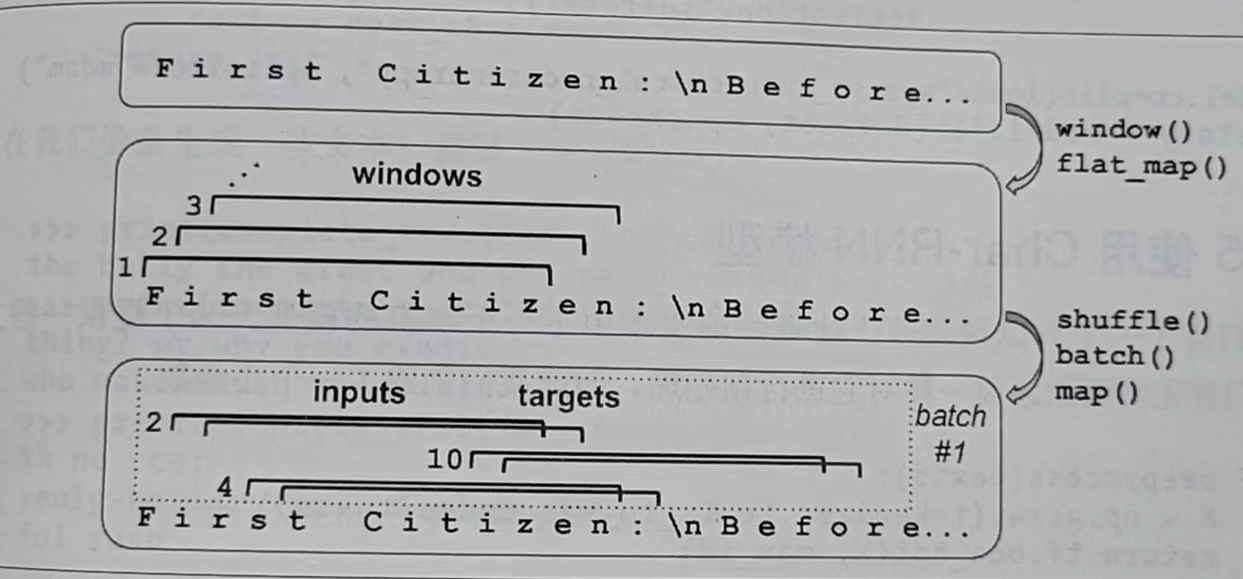

In [48]:
text_vec_layer = keras.layers.TextVectorization(split="character",
                                                   standardize="lower")
# 将不同长度的文本转换成相同长度的数组
text_vec_layer.adapt([shakespeare_text])
encoded = text_vec_layer([shakespeare_text])[0] # 把文本编码

In [49]:
encoded

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([21,  7, 10, ..., 22, 28, 12], dtype=int64)>

In [17]:
print(text_vec_layer.get_vocabulary())
print(len(text_vec_layer.get_vocabulary()))

['', '[UNK]', ' ', 'e', 't', 'o', 'a', 'i', 'h', 's', 'r', 'n', '\n', 'l', 'd', 'u', 'm', 'y', 'w', ',', 'c', 'f', 'g', 'b', 'p', ':', 'k', 'v', '.', "'", ';', '?', '!', '-', 'j', 'q', 'x', 'z', '3', '&', '$']
41


In [18]:
encoded -= 2  # 头两个字母不会用到，一个空字符一个UNKNOW，丢掉这两个编码
n_tokens = text_vec_layer.vocabulary_size() - 2  # number of distinct chars = 39
dataset_size = len(encoded)  # total number of chars = 1,115,394

In [19]:
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
    # 以上数据准备写为函数形式
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
    if shuffle:
        ds = ds.shuffle(100_000, seed=seed)
    ds = ds.batch(batch_size)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)


In [20]:
length = 100
train_set = to_dataset(encoded[:1_000_000], length=length, shuffle=True,
                       seed=42)
valid_set = to_dataset(encoded[1_000_000:1_060_000], length=length)
test_set = to_dataset(encoded[1_060_000:], length=length)

> 请勿运行下面一个代码格，可能需要60小时以上

In [ ]:
model = keras.Sequential([
    keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.Dense(n_tokens, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model_ckpt = keras.callbacks.ModelCheckpoint(
    "my_shakespeare_model", monitor="val_accuracy", save_best_only=True)
history = model.fit(train_set, validation_data=valid_set, epochs=10,
                    callbacks=[model_ckpt])

## 使用模型

In [22]:
from pathlib import Path
# 下载一个现成模型
url = "https://github.com/ageron/data/raw/main/shakespeare_model.tgz"
path = keras.utils.get_file("shakespeare_model.tgz", url, extract=True)
model_path = Path(path).with_name("shakespeare_model")
shakespeare_model = keras.models.load_model(model_path)

In [83]:
y_proba = shakespeare_model.predict(["To be or not to b"])[0, -1]
# 模型预测结果和输入等长，每个预测字符是每个原字符的下一个字符，因此取最后一个
y_pred = tf.argmax(y_proba)  # 选最大的概率的位置（序号）
text_vec_layer.get_vocabulary()[y_pred + 2] # 跳过前两个字符

1/1 [==============================] - 0s 47ms/step


'e'

In [84]:
# next_char函数用于返回一段文本的下一个字符
def next_char(text, temperature=1):
    y_proba = shakespeare_model.predict([text])[0, -1:]
    rescaled_logits = tf.math.log(y_proba) / temperature
    # temperature 越大，倾向于给所有字符相同概率，越小，越倾向于选概率高的字符
    char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
    # categorical()根据概率值采样，而非只选概率最高的
    return text_vec_layer.get_vocabulary()[char_id + 2]

In [86]:
def extend_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars): # 要生成的文本量
        text += next_char(text, temperature) # 反复调用，获得下一个字符并且添加到原文本
    return text

In [87]:
print(extend_text('t', temperature=0.2))

1/1 [==============================] - 0s 37ms/step
the true death,
and the very provost, and with the 


In [106]:
print(extend_text('To be or not to be', 100, temperature=0.8))

1/1 [==============================] - 0s 35ms/step
To be or not to be and come baw's woman?

duke vincentio:
i pray, i was hear, heaven for in him not knock
for that i m


## 有状态RNN

略过了

In [107]:
def to_dataset_for_stateful_rnn(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(length + 1)).batch(1)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

stateful_train_set = to_dataset_for_stateful_rnn(encoded[:1_000_000], length)
stateful_valid_set = to_dataset_for_stateful_rnn(encoded[1_000_000:1_060_000],
                                                 length)
stateful_test_set = to_dataset_for_stateful_rnn(encoded[1_060_000:], length)

In [108]:
list(to_dataset_for_stateful_rnn(tf.range(10), 3))

[(<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[0, 1, 2]])>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[1, 2, 3]])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[3, 4, 5]])>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[4, 5, 6]])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[6, 7, 8]])>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[7, 8, 9]])>)]

In [109]:
# extra code – shows one way to prepare a batched dataset for a stateful RNN

import numpy as np

def to_non_overlapping_windows(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    return ds.flat_map(lambda window: window.batch(length + 1))

def to_batched_dataset_for_stateful_rnn(sequence, length, batch_size=32):
    parts = np.array_split(sequence, batch_size)
    datasets = tuple(to_non_overlapping_windows(part, length) for part in parts)
    ds = tf.data.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows))
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

list(to_batched_dataset_for_stateful_rnn(tf.range(20), length=3, batch_size=2))

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 0,  1,  2],
         [10, 11, 12]])>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 1,  2,  3],
         [11, 12, 13]])>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 3,  4,  5],
         [13, 14, 15]])>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 4,  5,  6],
         [14, 15, 16]])>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 6,  7,  8],
         [16, 17, 18]])>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 7,  8,  9],
         [17, 18, 19]])>)]

In [110]:
model = keras.Sequential([
    keras.layers.Embedding(input_dim=n_tokens, output_dim=16,
                              batch_input_shape=[1, None]),
    keras.layers.GRU(128, return_sequences=True, stateful=True),
    keras.layers.Dense(n_tokens, activation="softmax")
])

情感分析，机器翻译，注意力机制，transformer等另外找资料学习